## Predicting Diabetes with Insulin

Using the k-nearest neighbors method, use the top-k most similar people to predict whether a person has diabetes or not

Use Jaccard similarity based on distances of people's health data to rank this data and select the top-k most similar health profiles

In [10]:
import csv

import pandas as pd
import numpy as np

from scipy.sparse import lil_matrix

import matplotlib.pyplot as plt

In [11]:


# Add an index column to a CSV file
def add_index_column(input_file, output_file):
    with open(input_file, "r") as infile, open(output_file, "w", newline='') as outfile:
        reader = csv.reader(infile)
        writer = csv.writer(outfile)

        # Read header
        header = next(reader)
        header.insert(0, "index")  # Insert "index" at the beginning of the header

        # Write updated header to output file
        writer.writerow(header)

        # Write rows with index to the output file
        for index, row in enumerate(reader, start=1):
            row.insert(0, index)  # Insert the index value at the beginning of each row
            writer.writerow(row)


input_file = "diabetes2.csv" 
output_file = "diabetes2_with_index.csv"  
add_index_column(input_file, output_file)


Create maps for person_outcome_map and insulin_person_map. The first contains each person's diabetes outcome with corresponding index; the second contains each person's insulin level, diabetes outcome, and corresponding index

In [12]:
import csv

person_outcome_map = {}
insulin_person_map = {}

# Read diabetes CSV
with open("diabetes2_with_index.csv", "r") as csvfile:
    csvreader = csv.DictReader(csvfile)

    for row in csvreader:

        index = row['index']
        insulin_level = row['Insulin']
        diabetes_outcome = row['Outcome']

        # Update person_outcome_map with automatically generated index
        person_outcome_map[index] = {"person": index, "diabetes_outcome": diabetes_outcome}

        # Update insulin_person_map with automatically generated index
        insulin_person_map[index] = {"insulin_level": insulin_level, "diabetes_outcome": diabetes_outcome}

# access the mappings:
# person_outcome_map contains each person's diabetes outcome with corresponding index
# insulin_person_map contains each person's insulin level, diabetes outcome, and corresponding index

# test index of 1
insulin_person_map['1']



{'insulin_level': '0', 'diabetes_outcome': '1'}

In [13]:
print("Known people:", len(insulin_person_map))
print("Known people:", len(person_outcome_map))

Known people: 768
Known people: 768


In [14]:
test_person_id = "1"
test_person_object = insulin_person_map[test_person_id]
test_person_object

{'insulin_level': '0', 'diabetes_outcome': '1'}



Calculate Jaccard similarity of people based on insulin level and append similarity to 'rows': 

In [15]:
rows = []

# Get the insulin level for the test person
test_insulin_level = test_person_object["insulin_level"]

# Iterate through each person in the insulin_person_map
for other_person_id, other_person_info in insulin_person_map.items():
    # Skip the test person
    if other_person_id == test_person_id:
        continue
    
    # Get the insulin level for the other person
    other_insulin_level = other_person_info["insulin_level"]
    
    # Calculate similarity based on insulin level 
    similarity = 1 / (1 + abs(float(other_insulin_level) - float(test_insulin_level)))
    
    rows.append({
        "person_id": other_person_id,
        "similarity": similarity
    })



In [16]:
similar_df = pd.DataFrame(rows)

In [17]:
similar_df.head(5)

,person_id,similarity
0,2,1.000000
1,3,1.000000
2,4,0.010526
3,5,0.005917
4,6,1.000000


In [18]:
tentop = 10
top_ten_df = similar_df.sort_values(by="similarity", ascending=False).head(tentop)
top_ten_df


,person_id,similarity
766,768,1.0
0,2,1.0
1,3,1.0
765,767,1.0
763,765,1.0
4,6,1.0
761,763,1.0
6,8,1.0
760,762,1.0
8,10,1.0


In [66]:
insulin_person_map['768']

{'insulin_level': '0', 'diabetes_outcome': '0'}

In [67]:
insulin_person_map['2']

{'insulin_level': '0', 'diabetes_outcome': '0'}

In [68]:
insulin_person_map['3']

{'insulin_level': '0', 'diabetes_outcome': '1'}

In [69]:
insulin_person_map['767']

{'insulin_level': '0', 'diabetes_outcome': '1'}

In [70]:
insulin_person_map['765']

{'insulin_level': '0', 'diabetes_outcome': '0'}

In [71]:
insulin_person_map['6']

{'insulin_level': '0', 'diabetes_outcome': '0'}

In [72]:
insulin_person_map['763']

{'insulin_level': '0', 'diabetes_outcome': '0'}

In [19]:
top_k = 5
top_k_df = similar_df.sort_values(by="similarity", ascending=False).head(top_k)
top_k_df

,person_id,similarity
766,768,1.0
0,2,1.0
1,3,1.0
765,767,1.0
763,765,1.0


In [20]:
# Initialize dictionary to store count of each combination of insulin level and diabetes outcome
insulin_diagnosis_count = {}

# Iterate through each person in top-k
for other_person_id in similar_df["person_id"]:
    other_person_info = insulin_person_map[other_person_id]
    
    # Access insulin level and diabetes outcome for other person
    insulin_level = other_person_info["insulin_level"]
    diabetes_outcome = other_person_info["diabetes_outcome"]
    
    # Combine insulin level and diabetes outcome into a tuple
    insulin_diagnosis = (insulin_level, diabetes_outcome)
    
    # Update dictionary count for the combination
    insulin_diagnosis_count[insulin_diagnosis] = insulin_diagnosis_count.get(insulin_diagnosis, 0) + 1



In [21]:
from collections import Counter

In [22]:
predicted_insulin_diagnosis = Counter(insulin_diagnosis_count).most_common(1)[0][0]

# Take predicted diagnosis from the tuple (insulin_level, diabetes_outcome)
predicted_diagnosis = predicted_insulin_diagnosis[1]
predicted_diagnosis

'0'

In [23]:
# Check if predicted diagnosis exists in test person's diabetes outcomes
predicted_diagnosis_in_test = predicted_diagnosis in test_person_object["diabetes_outcome"]
predicted_diagnosis_in_test

False

In [24]:
from collections import Counter

# Initialize Counter to store count of each insulin level/diabetes outcome combination
insulin_diagnosis_count = Counter()

# Iterate through each person in insulin_person_map
for person_info in insulin_person_map.values():
    insulin_level = person_info["insulin_level"]
    diabetes_outcome = person_info["diabetes_outcome"]
    
    # Combine insulin level and diabetes outcome into tuple
    insulin_diagnosis = (insulin_level, diabetes_outcome)
    
    # Increment the count for the combination in Counter
    insulin_diagnosis_count[insulin_diagnosis] += 1

# Calculate count of the most common combination
most_common_count = insulin_diagnosis_count.most_common(1)[0][1]

most_common_count

236

In [25]:
predicted_diagnosis_set = {g for g,i in insulin_diagnosis_count.items() if i == most_common_count}
predicted_diagnosis_set

{('0', '0')}

In [26]:
# Compare length of intersection and union of two sets: 
# predicted_diagnosies_set and diagnosis outcomes for test person

len(predicted_diagnosis_set.intersection(test_person_object["diabetes_outcome"])) == len(predicted_diagnosis_set.union(test_person_object["diabetes_outcome"]))

False

In [27]:
len(predicted_diagnosis_set.intersection(test_person_object["diabetes_outcome"])) / len(predicted_diagnosis_set.union(test_person_object["diabetes_outcome"]))

0.0

In [28]:
insulin_person_map["3"]

{'insulin_level': '0', 'diabetes_outcome': '1'}

In [29]:
test_person_object

{'insulin_level': '0', 'diabetes_outcome': '1'}

## Predict Diabetes Outcome

In [30]:
sim_outcomes = []

# Iterate through each person in top-k 
for other_person_id in top_k_df["person_id"]:
    # Take corresponding person object from insulin_person_map
    other_person_object = insulin_person_map[other_person_id]
    
    # Append the diabetes outcome of other person to sim_outcomes
    sim_outcomes.append(other_person_object["diabetes_outcome"])


In [31]:
top_k_df

,person_id,similarity
766,768,1.0
0,2,1.0
1,3,1.0
765,767,1.0
763,765,1.0


In [32]:
sim_outcomes

['0', '0', '1', '1', '0']

In [33]:
from collections import Counter

# Count occurrences of each diabetes outcome
outcome_counts = Counter(sim_outcomes)

# Print counts
print(outcome_counts)

Counter({'0': 3, '1': 2})


In [34]:
# Convert strings to integers
sim_outcomes_numeric = [int(outcome) for outcome in sim_outcomes]

# Calculate the mean
mean_outcome = np.mean(sim_outcomes_numeric)
mean_outcome

0.4

In [35]:
scores = []
for k in range(1,10):
    print(k)
    this_top_k_df = similar_df.sort_values(by="similarity", ascending=False).head(k)
    
    sim_outcomes = []
    for other_person_id in this_top_k_df["person_id"]:
        other_person_object = insulin_person_map[other_person_id]

        # convert to integer and append to sim_outcomes
        sim_outcomes.append(int(other_person_object["diabetes_outcome"]))

    # Calculate mean outcome & squared error
    mean_outcome = np.mean(sim_outcomes)
    squared_error = (mean_outcome - int(test_person_object["diabetes_outcome"])) ** 2

    # Print calculated scores
    print("Mean outcome:", mean_outcome)
    print("Squared error:", squared_error)
    
    scores.append({
        "k": k,
        "predicted_outcome": mean_outcome,
        "se": squared_error
    })

1
Mean outcome: 0.0
Squared error: 1.0
2
Mean outcome: 0.0
Squared error: 1.0
3
Mean outcome: 0.3333333333333333
Squared error: 0.44444444444444453
4
Mean outcome: 0.5
Squared error: 0.25
5
Mean outcome: 0.4
Squared error: 0.36
6
Mean outcome: 0.3333333333333333
Squared error: 0.44444444444444453
7
Mean outcome: 0.2857142857142857
Squared error: 0.5102040816326531
8
Mean outcome: 0.25
Squared error: 0.5625
9
Mean outcome: 0.3333333333333333
Squared error: 0.44444444444444453


In [36]:
pd.DataFrame(scores)

,k,predicted_outcome,se
0,1,0.000000,1.000000
1,2,0.000000,1.000000
2,3,0.333333,0.444444
3,4,0.500000,0.250000
4,5,0.400000,0.360000
5,6,0.333333,0.444444
6,7,0.285714,0.510204
7,8,0.250000,0.562500
8,9,0.333333,0.444444


<Axes: xlabel='k'>

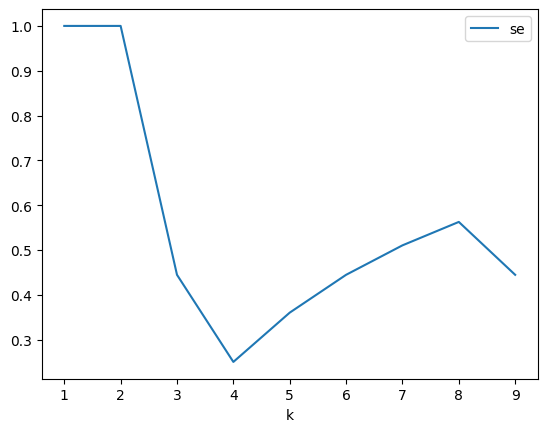

In [27]:
pd.DataFrame(scores).plot(x="k", y="se")

## Average Error Across k

In [37]:
import random

In [38]:
all_person_ids = list(insulin_person_map.keys())
random.shuffle(all_person_ids)

test_person_ids = all_person_ids[614:]
other_person_ids = all_person_ids[:614]

In [97]:
global_person_map = {}

test_person_id = '10'

# Check if test person ID is present in insulin_person_map
if test_person_id in insulin_person_map:
    # Take info about the test person from insulin_person_map
    test_person_object = insulin_person_map[test_person_id]

    scores = []

    # Iterate over k values
    for k in range(1, 20):
        # Sort similar_df by similarity and select top k rows
        this_top_k_df = similar_df.sort_values(by="similarity", ascending=False).head(k)

        # Initialize list to store outcomes for each similar person
        sim_outcomes = []

        # Iterate over person_ids in top k
        for other_person_id in this_top_k_df["person_id"]:
            other_person_object = insulin_person_map[other_person_id]

            # Append numeric outcome to sim_outcomes
            sim_outcomes.append(float(other_person_object["diabetes_outcome"]))  # Convert to float

        # Calculate mean of sim_outcomes
        mean_outcome = np.mean(sim_outcomes)

        # Convert target_person_object["diabetes_outcome"] to float
        target_diabetes_outcome = float(test_person_object["diabetes_outcome"])

        # Determine predicted outcome based on rounded mean
        predicted_diabetes = round(mean_outcome)

        # Calculate squared error
        squared_error = (mean_outcome - target_diabetes_outcome) ** 2

        # Append k, predicted_outcome, and squared error to scores list
        scores.append({
            "k": k,
            "predicted_outcome": predicted_diabetes,
            "se": squared_error
        })

    # Convert scores list to DataFrame and store in global_person_map
    global_person_map[test_person_id] = pd.DataFrame(scores)

    # Get predicted outcome for test person from global_person_map
    predicted_df = global_person_map[test_person_id]

    # Get the predicted outcome for  test person
    predicted_outcome = predicted_df[predicted_df["k"] == 8]["predicted_outcome"].values[0]  # Replace k with the desired value of k

    # Get the actual outcome for the test person from the insulin_person_map
    actual_outcome = float(test_person_object.get("diabetes_outcome", -1))

    if actual_outcome != -1:
        # Compare the predicted outcome with the actual outcome
        if predicted_outcome == actual_outcome:
            print("Prediction is correct!")
        else:
            print("Prediction is incorrect!")
    else:
        print("Actual outcome not available for the test person.")
else:
    print("Test person not found in insulin_person_map.")




Prediction is incorrect!


In [64]:
global_person_map

{'2':      k  predicted_outcome        se
 0    1                  0  0.000000
 1    2                  0  0.000000
 2    3                  0  0.111111
 3    4                  0  0.250000
 4    5                  0  0.160000
 5    6                  0  0.111111
 6    7                  0  0.081633
 7    8                  0  0.062500
 8    9                  0  0.111111
 9   10                  0  0.160000
 10  11                  0  0.132231
 11  12                  0  0.173611
 12  13                  0  0.147929
 13  14                  0  0.183673
 14  15                  0  0.160000
 15  16                  0  0.191406
 16  17                  0  0.221453
 17  18                  0  0.250000
 18  19                  0  0.224377}

In [65]:
k_se_scores = {}
for k_df in global_person_map.values():
    for _,row in k_df.iterrows():
        k_se_scores[row["k"]] = k_se_scores.get(row["k"], []) + [row["se"]]

In [71]:
np.mean(k_se_scores[4])

0.25

In [67]:
np.mean(k_se_scores[3])

0.1111111111111111

In [68]:
np.mean(k_se_scores[5])

0.16000000000000003

In [69]:
np.mean(k_se_scores[6])

0.1111111111111111

In [72]:
np.mean(k_se_scores[7])

0.08163265306122448

In [73]:
np.mean(k_se_scores[8])

0.0625

In [74]:
np.mean(k_se_scores[9])

0.1111111111111111

In [75]:
np.mean(k_se_scores[10])

0.16000000000000003

<Axes: xlabel='0'>

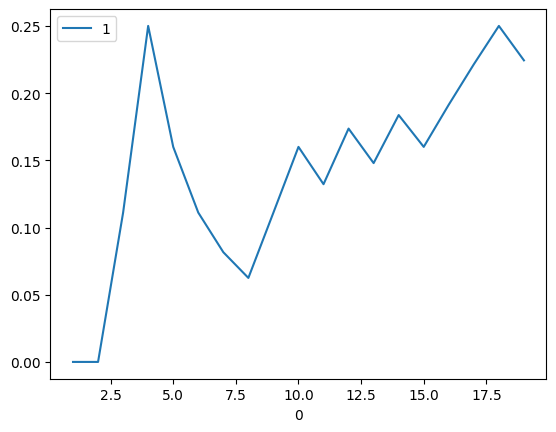

In [76]:
pd.DataFrame([(k,np.mean(v)) for k,v in k_se_scores.items()]).plot(x=0, y=1)

In [98]:
# Initialize counts
count_diabetes_0 = 0
count_diabetes_1 = 0

# Iterate through insulin_person_map
for index, person_info in insulin_person_map.items():
    insulin_level = person_info["insulin_level"]
    diabetes_outcome = person_info["diabetes_outcome"]

    # Check if insulin level is 0 and diabetes outcome is 0 or 1
    if insulin_level == '0':
        if diabetes_outcome == '0':
            count_diabetes_0 += 1
        elif diabetes_outcome == '1':
            count_diabetes_1 += 1

print("Instances of insulin level 0 for individuals with diabetes outcome 0:", count_diabetes_0)
print("Instances of insulin level 0 for individuals with diabetes outcome 1:", count_diabetes_1)


Instances of insulin level 0 for individuals with diabetes outcome 0: 236
Instances of insulin level 0 for individuals with diabetes outcome 1: 138
